# Error Stats vs Different seq_len

(320, 4)


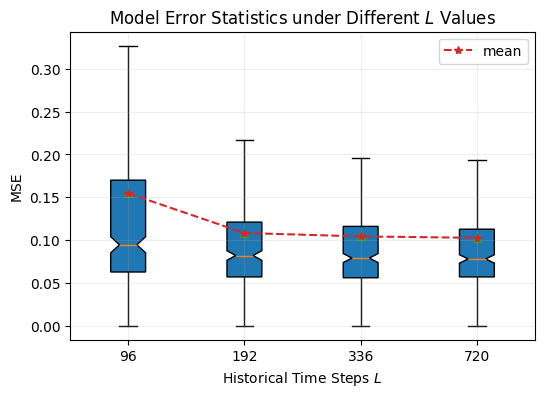

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

model_names = ["Linear", "DLinear", "NLinear"]
data = []
for model in model_names:
  result_path = "../result-{}.txt".format(model)

  with open(result_path, "r") as file:
    lines = file.read().split("\n\n")
  mse, mae, rse, tg = [], [], [], []

  for line in lines:
    if 'tg' in line:
      tg.append(int(line.split('tg')[1].split('_')[0]))
    if 'mse' in line:
      mse.append(round(float(line.split('mse:')[1].split(',')[0]), 3))
    if 'mae' in line:
      mae.append(round(float(line.split('mae:')[1].split(',')[0]), 3))
    if 'rse' in line:
      rse.append(round(float(line.split('rse:')[1].split(',')[0]), 3))
  data.append(mse)

idx = ['96', '192', '336', '720']
cols = list(dict.fromkeys(tg))

x1 = np.reshape(data[0], (int(len(data[0])/len(idx)), len(idx)))
x2 = np.reshape(data[1], (int(len(data[1])/len(idx)), len(idx)))
x3 = np.reshape(data[2], (int(len(data[2])/len(idx)), len(idx)))

print(x1.shape)
x_mean = [np.mean(t) for t in x1.T]

fig, ax = plt.subplots(figsize=(6, 4))
showfliers = False
showmeans = True
patch_artist = True
positions = np.arange(1, len(idx)+1)
# print(positions)
width = 0.3
widths = tuple([width] * len(idx))

ax.boxplot(x1, positions=positions, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
# ax.boxplot(x2, positions=positions, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
# ax.boxplot(x3, positions=positions + width, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
ax.plot(positions, x_mean, '--', color='tab:red', marker='*', label='mean', zorder=2)
ax.grid(alpha=0.2)
ax.legend()
ax.set_xticklabels(idx)
ax.set_title("Model Error Statistics under Different {} Values".format('$\mathit{L}$'))
ax.set_xlabel('Historical Time Steps {}'.format('$\mathit{L}$'))
ax.set_ylabel("MSE")
fig.savefig('error_stat.pdf')

# Aggregate Models

Model(
  (Linear): Linear(in_features=720, out_features=24, bias=True)
) with 17304 parameters
tensor([[[4196.3628],
         [3836.9534],
         [3484.6255],
         [3171.6021],
         [2961.2351],
         [3080.6077],
         [2865.0957],
         [2750.0071],
         [2954.9578],
         [3556.8943],
         [4122.8159],
         [4962.8218],
         [5468.5239],
         [4938.0308],
         [4677.5400],
         [4344.7642],
         [4394.7690],
         [4906.1250],
         [5874.3003],
         [6647.4531],
         [6370.3950],
         [6120.6641],
         [5637.2134],
         [4994.0132]]], grad_fn=<PermuteBackward0>)


/mnt/zkpet/venv/lib/python3.10/site-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


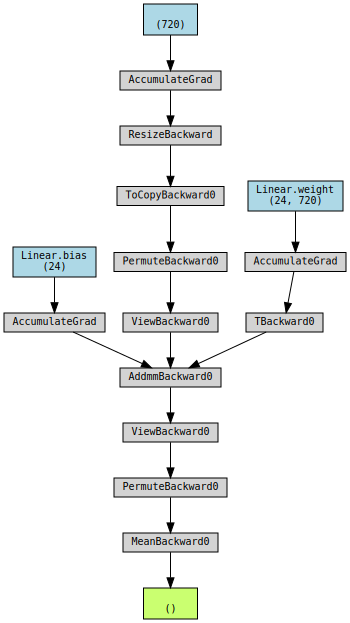

In [1]:
import torch
from torchviz import make_dot
import pandas as pd
import sys
sys.path.append("..")
from models.DLinear import Model as DLinear
from models.Linear import Model as Linear
from models.NLinear import Model as NLinear


class Configs:
    def __init__(self, seq_len, pred_len):
      self.seq_len = seq_len
      self.pred_len = pred_len
      self.enc_in = 321
      self.individual = False

model = 'Linear'
target = '40'
seq_len = 192
pred_len = 24

configs = Configs(seq_len, pred_len)
match model:
  case 'Linear':
    circuit = Linear(configs)
  case 'DLinear':
    circuit = DLinear(configs)
  case 'NLinear':
    circuit = NLinear(configs)

basepath = '../checkpoints/Electricity_{}_{}_{}_custom_ftS_tg{}_sl{}_ll48_pl{}_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth'
check_point_model = basepath.format(seq_len, pred_len, model, target, seq_len, pred_len)

state_dict = torch.load(check_point_model)
circuit.load_state_dict(state_dict)

total_params = sum(
	param.numel() for param in circuit.parameters()
)

print(circuit, 'with {} parameters'.format(total_params))

df = pd.read_csv('../dataset/electricity.csv')
# Load the last seq_len entries data as input and converts to tensor
# x = 10*torch.rand(1,*[seq_len, 1], requires_grad=True)
x = torch.tensor(df[target][-seq_len:].values, requires_grad=True).resize(1, seq_len, 1).float()
# Flips the neural net into inference mode
circuit.eval()

y = circuit(x)
print(y)

# Visualize the trained model
# make_dot(y.mean(), params=dict(circuit.named_parameters()), show_attrs=True, show_saved=True)
make_dot(y.mean(), params=dict(circuit.named_parameters()))
# img = make_dot(y.mean(), params=dict(circuit.named_parameters()))
# img.render(model, format="png")

In [19]:
import torch
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append("..")
from models.DLinear import Model as DLinear
from models.Linear import Model as Linear
from models.NLinear import Model as NLinear
import warnings
warnings.filterwarnings("ignore")

class Configs:
    def __init__(self, seq_len, pred_len):
      self.seq_len = seq_len
      self.pred_len = pred_len
      self.enc_in = 321
      self.individual = False

def plot_aggr():
    seq_lens = [96, 192, 336, 720]
    model = 'Linear'
    pred_len = 24
    pred_aggrs = []

    for seq_len in seq_lens:

      configs = Configs(seq_len, pred_len)
      match model:
        case 'Linear':
          circuit = Linear(configs)
        case 'DLinear':
          circuit = DLinear(configs)
        case 'NLinear':
          circuit = NLinear(configs)
          
      basepath = '../checkpoints/Electricity_{}_{}_{}_custom_ftS_tg{}_sl{}_ll48_pl{}_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth'
      df = pd.read_csv('../dataset/electricity.csv')
      df_pred = df[['date']][-pred_len:]

      for target in range(320):
          check_point_model = basepath.format(seq_len, pred_len, model, target, seq_len, pred_len)
          state_dict = torch.load(check_point_model)
          circuit.load_state_dict(state_dict)
          # Load the last seq_len entries data as input and converts to tensor
          x = torch.tensor(df[str(target)][-(seq_len+pred_len):-pred_len].values, requires_grad=True).resize(1, seq_len, 1).float()
          # Flips the neural net into inference mode
          circuit.eval()
          y = circuit(x)
          df_pred[str(target)] = (y.detach().cpu().numpy()[0].flatten())

      df_pred['Agg_Prediction'] = df_pred.iloc[:, 1:].sum(axis=1)
      df_aggr = df[-pred_len:].set_index('date')
      df_aggr['Agg_GroundTruth'] = df_aggr.iloc[:, 1:-1].sum(axis=1)

      x_data = [dt.split(':')[0] for dt in df_aggr.index.values]
      y_pred = df_pred['Agg_Prediction'].values
      pred_aggrs.append(y_pred)
      y_truth = df_aggr['Agg_GroundTruth'].values

    fig, ax = plt.subplots(figsize=(6, 4))
    # Plot aggregated true load
    ax.plot(x_data, y_truth, label='GroundTruth')
    # Plot aggregated predicted load
    i = 0
    for y_pred in pred_aggrs:
        ax.plot(x_data, y_pred, '--', label='Prediction(seq_len={})'.format(seq_lens[i]))
        i+=1

    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    xticks_label = np.arange(0,24)
    ax.set(xlabel='Hours', xticklabels=xticks_label, ylabel='Aggregated Electricity Load (KWh)', title='Linear Aggregated Performance'.format(seq_len))
    ax.legend(bbox_to_anchor=(0.63,0.4))
    # plt.xticks(rotation=30, ha='right')
    plt.show()
    fig.savefig('aggr_perf.png')
    fig.savefig('aggr_perf.pdf')

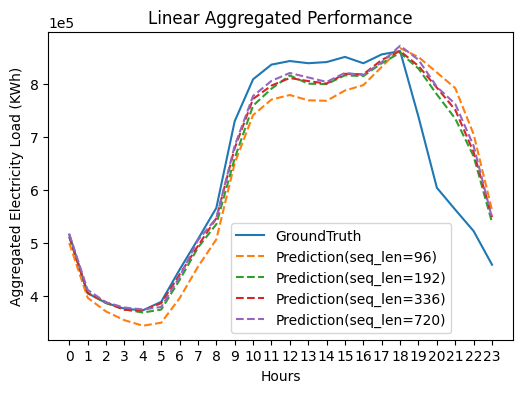

In [20]:
plot_aggr()

In [4]:
import pandas as pd
import numpy as np

data = "../dataset/electricity.csv"
df = pd.read_csv(data, parse_dates=['date'], date_format='%Y-%m-%d %H:%M:%S', index_col=['date'])

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Energy Demand')]

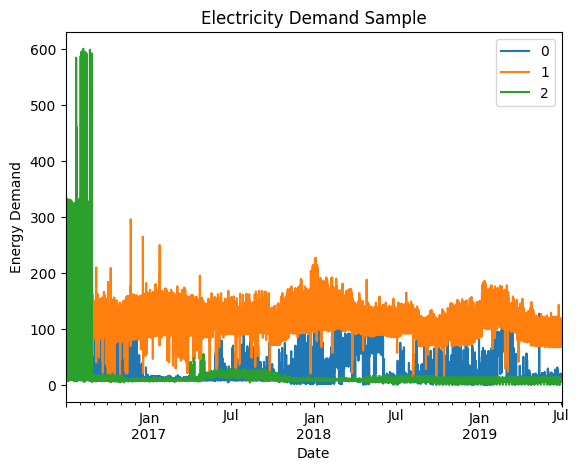

In [8]:
cols = df.columns.values
ax = df[cols[0:3]].plot(title='Electricity Demand Sample')
ax.set(xlabel='Date', ylabel='Energy Demand')

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df.head()

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,OT
date,,,,,,,,,,,,,,,,,,,,,
2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
2016-07-01 05:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
2016-07-01 06:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


<Axes: xlabel='date'>

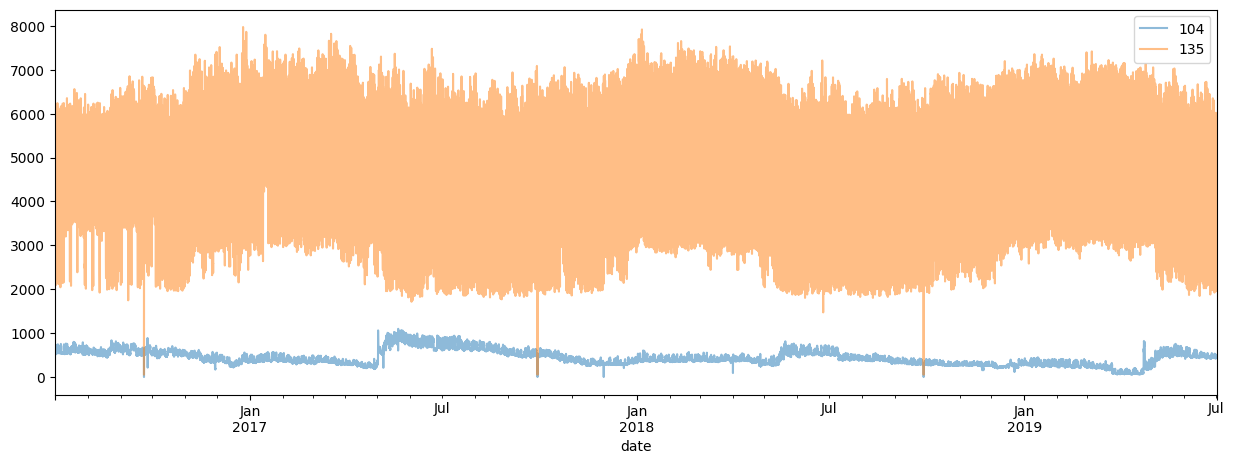

In [15]:
df[['104', '135']].plot(figsize = (15, 5), alpha = 0.5)

In [5]:
def decompose(df, column_name):
    """
    A function that returns the trend, seasonality and residual captured by applying both multiplicative and
    additive model.
    df -> DataFrame
    column_name -> column_name for which trend, seasonality is to be captured
    """
    result_mul = seasonal_decompose(df[column_name], model='multiplicative', extrapolate_trend = 'freq')
    result_add = seasonal_decompose(df[column_name], model = 'additive', extrapolate_trend='freq')

    plt.rcParams.update({'figure.figsize': (20, 10)})
    result_mul.plot().suptitle('Multiplicative Decompose', fontsize=30)
    result_add.plot().suptitle('Additive Decompose', fontsize=30)
    plt.show()
    
    return result_mul, result_add

In [10]:
df.loc[:, (df != 0).all()]

,104,127,129,130,135,136,137,138,139,142,...,272,273,274,275,276,277,279,280,282,283
date,,,,,,,,,,,,,,,,,,,,,
2016-07-01 02:00:00,403.0,263.0,76.0,105.0,2465.0,258.0,92.0,694.0,333.0,181.0,...,363.0,203.0,209.0,213.0,3199.0,720.0,640.0,1062.0,511.0,159.0
2016-07-01 03:00:00,544.0,262.0,69.0,108.0,2333.0,255.0,87.0,700.0,329.0,192.0,...,364.0,189.0,203.0,217.0,3078.0,706.0,610.0,1048.0,517.0,164.0
2016-07-01 04:00:00,528.0,261.0,67.0,111.0,2421.0,261.0,90.0,661.0,299.0,186.0,...,371.0,177.0,191.0,217.0,2967.0,642.0,613.0,1014.0,489.0,161.0
2016-07-01 05:00:00,553.0,262.0,69.0,104.0,2399.0,267.0,88.0,649.0,314.0,178.0,...,371.0,170.0,188.0,209.0,2907.0,696.0,601.0,987.0,511.0,166.0
2016-07-01 06:00:00,543.0,261.0,68.0,106.0,2300.0,258.0,79.0,652.0,299.0,184.0,...,349.0,178.0,190.0,215.0,3163.0,673.0,591.0,953.0,524.0,160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-01 21:00:00,449.0,180.0,369.0,125.0,4126.0,545.0,155.0,898.0,559.0,295.0,...,520.0,368.0,348.0,390.0,4762.0,1637.0,779.0,2231.0,705.0,371.0
2019-07-01 22:00:00,454.0,172.0,344.0,119.0,2850.0,464.0,118.0,609.0,453.0,177.0,...,384.0,242.0,223.0,274.0,3150.0,1236.0,581.0,945.0,665.0,185.0
2019-07-01 23:00:00,444.0,168.0,240.0,101.0,2674.0,335.0,119.0,516.0,419.0,179.0,...,389.0,233.0,204.0,254.0,3261.0,1156.0,458.0,965.0,639.0,178.0


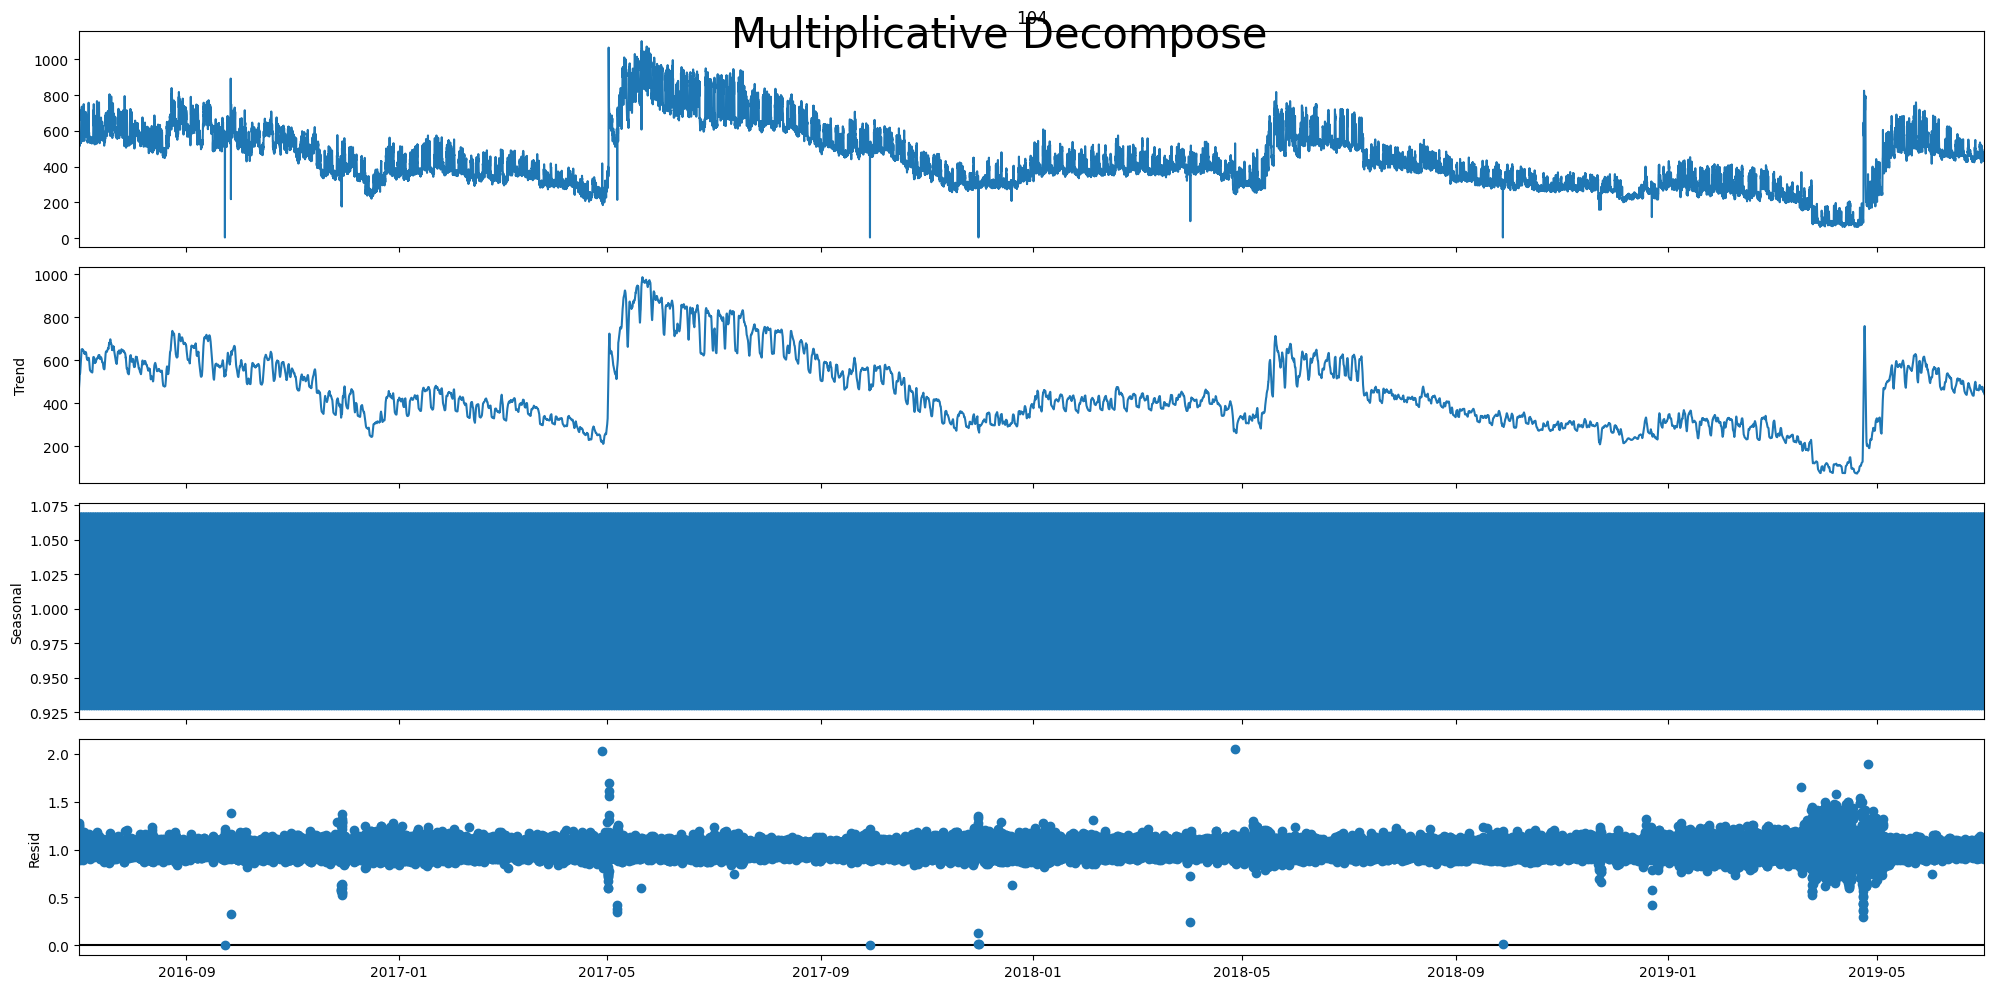

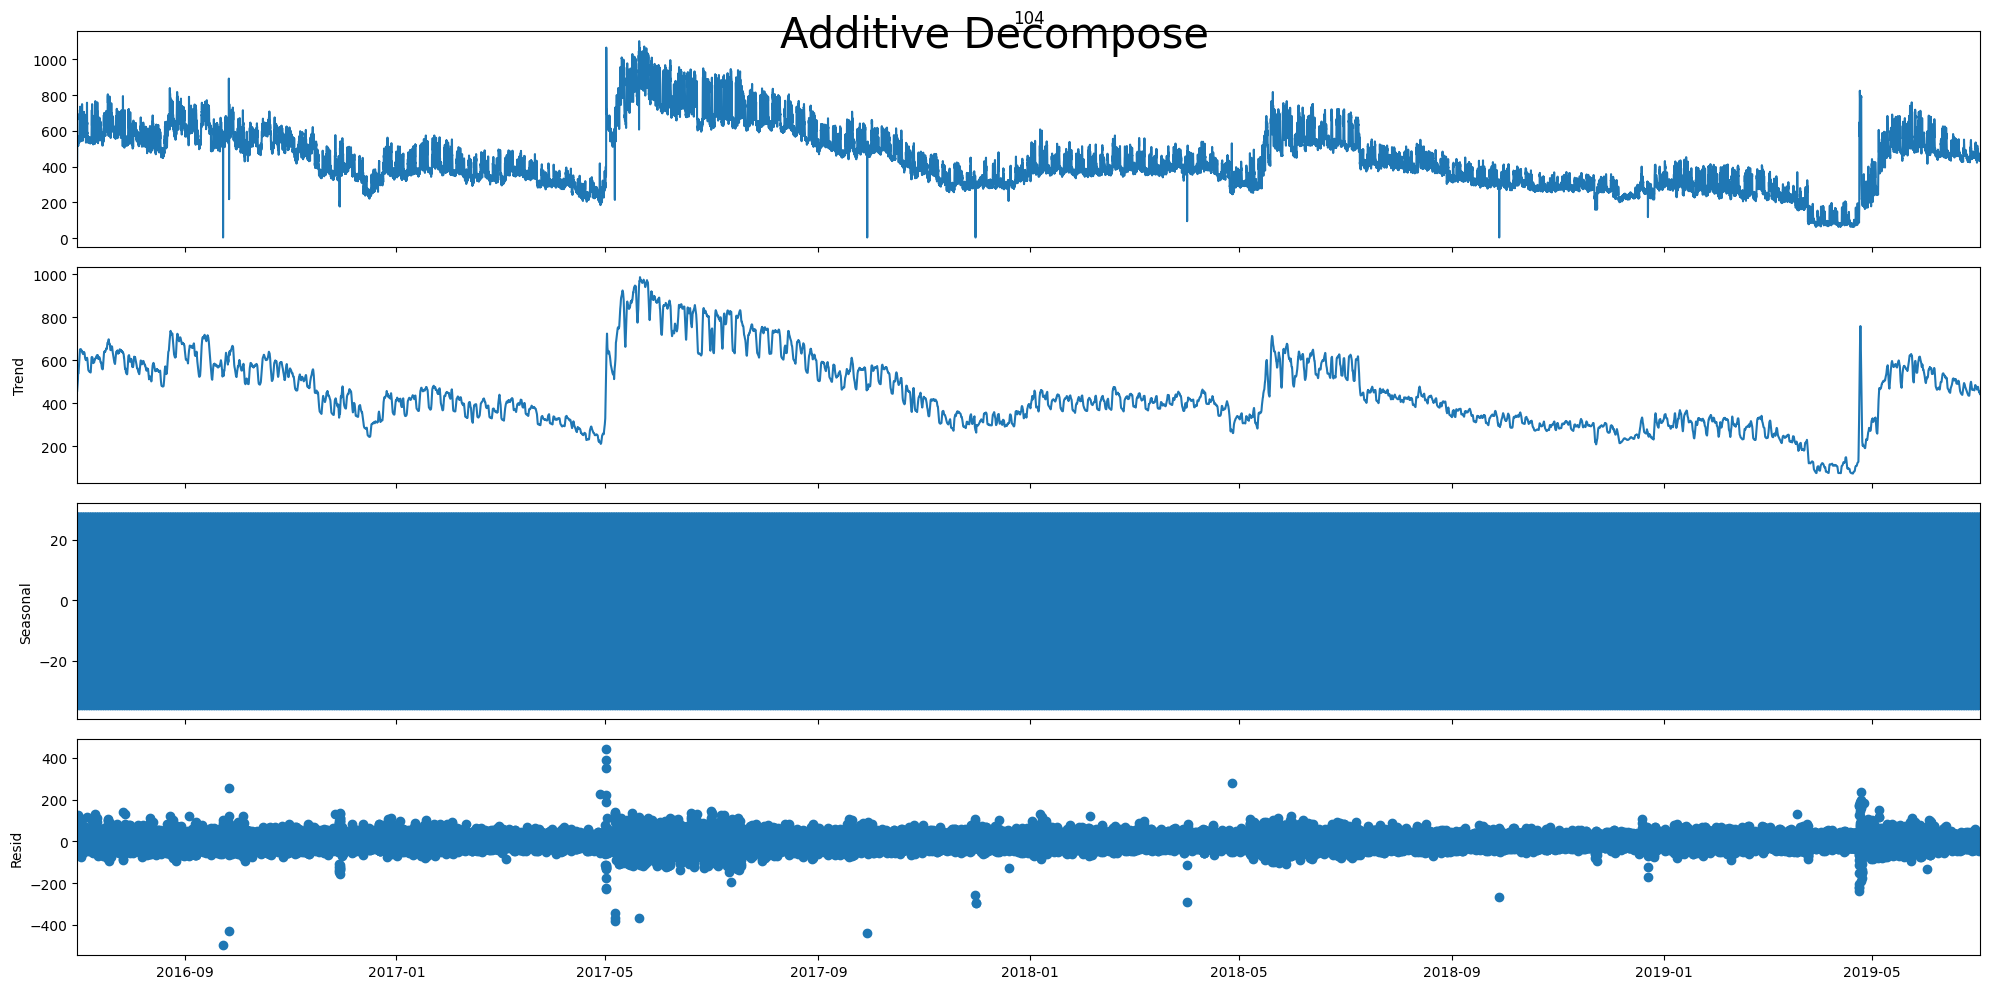

In [17]:
result_mul, result_add = decompose(df, '104')

# Centralized ZKML Performance Profile

In [39]:
import os

num_homes = np.array([10, 20, 30])
base_folder="/mnt/zkpet/checkpoints/Electricity_192_24_Linear_custom_ftM_sl192_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0_{}"

percent_cpu = []
prove_time = []
prove_max_ram = []

for target in num_homes:
  basepath = base_folder.format(target)
  perf_log = os.path.join(basepath, "perf.txt")

  with open(perf_log) as f:
    log = f.readlines()
    cpu = int(log[3].split(': ')[1].split('%')[0]) # cpu in percent
    percent_cpu.append(cpu)
    time = float(log[4].split(':')[-1]) # time in seconds
    prove_time.append(time)
    ram = round(int(log[9].split(': ')[1]) / 1024, 2) # ram in megabytes
    prove_max_ram.append(ram)

In [40]:
print(prove_max_ram, prove_time, percent_cpu)

[1136.7, 4516.71, 9000.66] [23.74, 33.68, 17.23] [352, 351, 343]


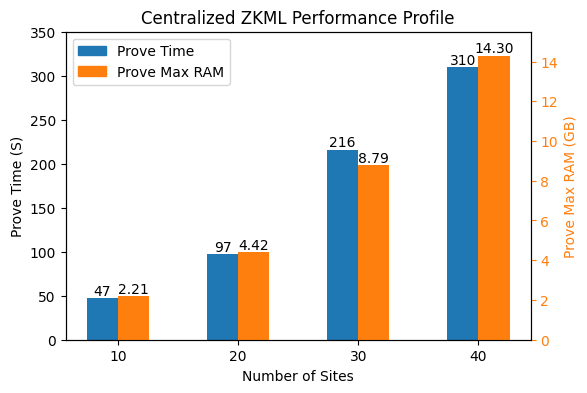

In [6]:
import matplotlib.pyplot as plt
import numpy as np

num_homes = np.array([10, 20, 30, 40])
prove_times = [47, 97, 216, 310]
max_mems = np.array([2258, 4523, 8998, 14642]) / 1024

fig, ax = plt.subplots(figsize=(6, 4))
width=2.6
lns1 = ax.bar(x=num_homes-width/2, height=prove_times, width=width, color='tab:blue', label='Prove Time')
ax.set(ylabel='Prove Time (S)', title='Centralized ZKML Performance Profile')
ax.set_xlabel('Number of Sites')
ax.bar_label(lns1, fmt='{:,.0f}')
ax.set_ylim([0, 350])

ax1 = ax.twinx() 
lns2 = ax1.bar(num_homes+width/2, max_mems, width=width, color='tab:orange', label='Prove Max RAM')
ax1.set_xticks(ticks=num_homes)
ax1.bar_label(lns2, fmt='{:,.2f}')
ax1.set_ylim([0, 15.5])
ax1.set_ylabel('Prove Max RAM (GB)', color='tab:orange')
ax1.tick_params(axis='y',colors='tab:orange')



colors = {'Prove Time':'tab:blue', 'Prove Max RAM':'tab:orange'}
labels = list(['Prove Time', 'Prove Max RAM'])
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()
fig.savefig('cent_perf.pdf')

# Decentralized ZKML Performance Profile

In [2]:
import os

seq_len = 192
pred_len = 24
model = "Linear"
node_num = 320

percent_cpu, percent_cpu_aggr = [],[]
prove_time, prove_time_aggr = [], []
prove_max_ram, prove_max_ram_aggr = [], []

for target in range(node_num):
  target = str(target)
  basepath = '../checkpoints/Electricity_{}_{}_{}_custom_ftS_tg{}_sl{}_ll48_pl{}_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0'
  basepath = basepath.format(seq_len, pred_len, model, target, seq_len, pred_len)
  perf_log = os.path.join(basepath, "perf.txt")
  perf_aggr_log = os.path.join(basepath, "perf_aggr.txt")

  with open(perf_log) as f:
    log = f.readlines()
    cpu = int(log[3].split(': ')[1].split('%')[0]) # cpu in percent
    percent_cpu.append(cpu)
    time = float(log[4].split(':')[-1]) # time in seconds
    prove_time.append(time)
    ram = round(int(log[9].split(': ')[1]) / 1024, 2) # ram in megabytes
    prove_max_ram.append(ram)

  with open(perf_aggr_log) as f:
    log = f.readlines()
    cpu = int(log[3].split(': ')[1].split('%')[0]) # cpu in percent
    percent_cpu_aggr.append(cpu)
    time = float(log[4].split(':')[-1]) # time in seconds
    prove_time_aggr.append(time)
    ram = round(int(log[9].split(': ')[1]) / 1024, 2) # ram in megabytes
    prove_max_ram_aggr.append(ram)

In [3]:
import numpy as np
percent_cpu = np.array([percent_cpu, percent_cpu_aggr]).T
prove_time = np.array([prove_time, prove_time_aggr]).T
prove_max_ram = np.array([prove_max_ram, prove_max_ram_aggr]).T

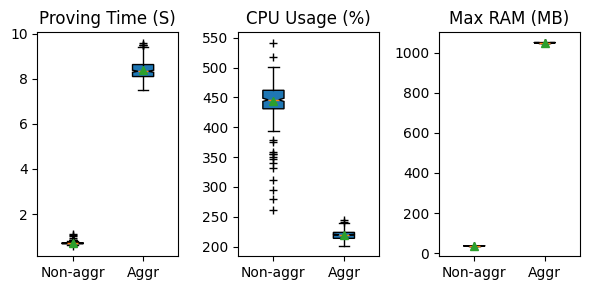

In [4]:
import matplotlib.pyplot as plt
idx_list = ['CPU Usage (%)', 'Proving Time (S)', 'Max RAM (MB)']

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(6, 3))
showfliers = True
showmeans = True
patch_artist = True
width = 0.3
widths = tuple([width] * 2)
positions = np.arange(1, len(percent_cpu.T)+1)

axes[0].boxplot(prove_time, positions=positions, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
# axes[0].set_xticklabels(["Time (S)"])
axes[0].set_xticklabels(["Non-aggr", "Aggr"])
axes[0].set_title(idx_list[1])

axes[1].boxplot(percent_cpu, positions=positions, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
# axes[1].set_xticklabels(['CPU (%)'])
axes[1].set_xticklabels(["Non-aggr", "Aggr"])

axes[1].set_title(idx_list[0])

axes[2].boxplot(prove_max_ram, positions=positions, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
# axes[2].set_xticklabels(['RAM (MB)'])
axes[2].set_xticklabels(["Non-aggr", "Aggr"])
axes[2].set_title(idx_list[2])

plt.tight_layout()
plt.show()
fig.savefig('aggr_vs_nonaggr_perf.pdf')

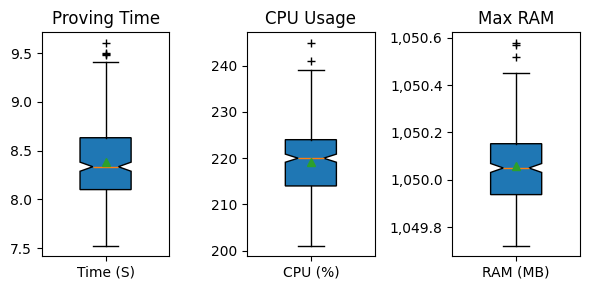

In [5]:
# Aggregation proving performance
import os
import matplotlib.pyplot as plt
import matplotlib

seq_len = 192
pred_len = 24
model = "Linear"
node_num = 320

percent_cpu = []
prove_time = []
prove_max_ram = []

for target in range(node_num):
  target = str(target)
  basepath = '../checkpoints/Electricity_{}_{}_{}_custom_ftS_tg{}_sl{}_ll48_pl{}_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0'
  basepath = basepath.format(seq_len, pred_len, model, target, seq_len, pred_len)
  perf_log = os.path.join(basepath, "perf_aggr.txt")

  with open(perf_log) as f:
    log = f.readlines()
    cpu = int(log[3].split(': ')[1].split('%')[0]) # cpu in percent
    percent_cpu.append(cpu)
    time = float(log[4].split(':')[-1]) # time in seconds
    prove_time.append(time)
    ram = round(int(log[9].split(': ')[1]) / 1024, 2) # ram in megabytes
    prove_max_ram.append(ram)

idx_list = ['CPU Usage', 'Proving Time', 'Max RAM']

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(6, 3))
showfliers = True
showmeans = True
patch_artist = True
width = 0.4
widths = tuple([width] * 1)

axes[0].boxplot(prove_time, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
axes[0].set_xticklabels(["Time (S)"])
axes[0].set_title(idx_list[1])

axes[1].boxplot(percent_cpu, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
axes[1].set_xticklabels(['CPU (%)'])
axes[1].set_title(idx_list[0])

axes[2].boxplot(prove_max_ram, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
axes[2].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(float(x), ',')))
axes[2].set_xticklabels(['RAM (MB)'])
axes[2].set_title(idx_list[2])

plt.tight_layout()
plt.show()
fig.savefig('fed_aggr_perf.pdf')

# Federated ZKML Performance (cluster=0)
2: array([  0,   2,   4,   6,   9,  11,  12,  25,  29,  36,  46,  50,  57,
         59,  68,  70,  75,  81,  83,  84,  85,  86,  87,  97,  98,  99,
        103, 104, 105, 106, 107, 111, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
        133, 146, 182, 245, 270, 298, 299, 303, 310, 317, 318, 319, 320])

In [14]:
import os
import pandas as pd
import numpy as np

seq_len = 192
pred_len = 24
model = "Linear"
# node_num = 320
# df = pd.read_csv('../dataset/electricity.csv')
sites = np.array([  0,   2,   4,   6,   9,  11,  12,  25,  29,  36,  46,  50,  57,
         59,  68,  70,  75,  81,  83,  84,  85,  86,  87,  97,  98,  99,
        103, 104, 105, 106, 107, 111, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
        133, 146, 182, 245, 270, 298, 299, 303, 310, 317, 318, 319])
percent_cpu = []
prove_time = []
prove_max_ram = []

for target in sites:
  target = str(target)
  basepath = '../checkpoints/Electricity_{}_{}_{}_custom_ftS_tg{}_sl{}_ll48_pl{}_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0'
  basepath = basepath.format(seq_len, pred_len, model, target, seq_len, pred_len)
  perf_log = os.path.join(basepath, "fed_prove_perf.txt")

  with open(perf_log) as f:
    log = f.readlines()
    cpu = int(log[3].split(': ')[1].split('%')[0]) # cpu in percent
    percent_cpu.append(cpu)
    time = float(log[4].split(':')[-1]) # time in seconds
    prove_time.append(time)
    ram = round(int(log[9].split(': ')[1]) / 1024, 2) # ram in megabytes
    prove_max_ram.append(ram)

# prove time by linux time measurement
print('Mean prove time: ', np.round(np.mean(prove_time), 2))
print('Mean CPU usage: ', np.round(np.mean(percent_cpu), 2))
print('Mean MAX RAM: ', np.round(np.mean(prove_max_ram), 2))

Mean prove time:  8.15
Mean CPU usage:  220.41
Mean MAX RAM:  1050.25


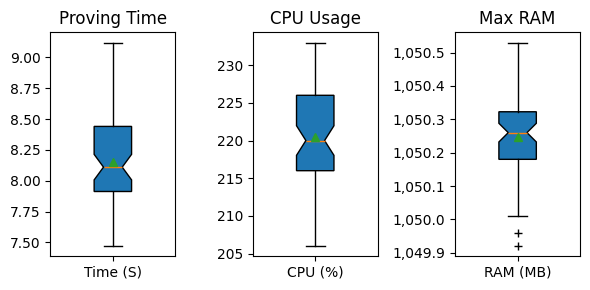

In [15]:
import matplotlib.pyplot as plt
import matplotlib

idx_list = ['CPU Usage', 'Proving Time', 'Max RAM']

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(6, 3))
showfliers = True
showmeans = True
patch_artist = True
width = 0.3
widths = tuple([width] * 1)

axes[0].boxplot(prove_time, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
# prove time reported by ezkl
# axes[1].boxplot(res, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
axes[0].set_xticklabels(["Time (S)"])
axes[0].set_title(idx_list[1])

axes[1].boxplot(percent_cpu, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
axes[1].set_xticklabels(['CPU (%)'])
axes[1].set_title(idx_list[0])

axes[2].boxplot(prove_max_ram, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
axes[2].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(float(x), ',')))
axes[2].set_xticklabels(['RAM (MB)'])
axes[2].set_title(idx_list[2])


plt.tight_layout()
plt.show()
fig.savefig('federated_perf.pdf')

# Proving Accuracy Comparison
Accuracy of the difference between actual predictions and calibrated predictions. Quantization calibration aims at balancing the accuracy and efficiency.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

models = ['cent', 'aggr', 'fed']
titles = ['Centralized', 'Decentralized', 'Federated']
dfs = []
for model in models:
  logfile = "../log_{}.txt".format(model)
  with open(logfile, "r") as file:
    lines = file.readlines()
  error_lines = []
  for i in np.arange(len(lines)):
    if "mean_error " in lines[i]:
      data = lines[i+2].strip().split(' |')
      error_lines.append(data)
  errors = []
  for l in error_lines:
    d = [float(e.strip()) for e in l[1:-1]]
    errors.append(d)
  error_labels = ["mean_error", "median_error", "max_error", "min_error", 
                  "mean_abs_error", "median_abs_error", "max_abs_error", 
                  "min_abs_error", "mean_squared_error", "mean_percent_error", 
                  "mean_abs_percent_error"]

  df = pd.DataFrame(data = np.array(errors), columns=error_labels)
  dfs.append(df[["mean_abs_error", "median_abs_error"]])

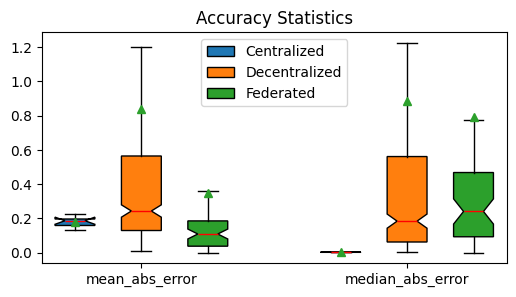

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

models = ['cent', 'aggr', 'fed']
titles = ['Centralized', 'Decentralized', 'Federated']
dfs = []
for model in models:
  logfile = "../log_{}.txt".format(model)
  with open(logfile, "r") as file:
    lines = file.readlines()
  error_lines = []
  for i in np.arange(len(lines)):
    if "mean_error " in lines[i]:
      data = lines[i+2].strip().split(' |')
      error_lines.append(data)
  errors = []
  for l in error_lines:
    d = [float(e.strip()) for e in l[1:-1]]
    errors.append(d)
  error_labels = ["mean_error", "median_error", "max_error", "min_error", 
                  "mean_abs_error", "median_abs_error", "max_abs_error", 
                  "min_abs_error", "mean_squared_error", "mean_percent_error", 
                  "mean_abs_percent_error"]

  df = pd.DataFrame(data = np.array(errors), columns=error_labels)
  dfs.append(df[["mean_abs_error", "median_abs_error"]])


data1 = dfs[0][["mean_abs_error", "median_abs_error"]].values
data2 = dfs[1][["mean_abs_error", "median_abs_error"]].values
data3 = dfs[2][["mean_abs_error", "median_abs_error"]].values

fig, ax = plt.subplots(figsize=(6,3))
bp1 = ax.boxplot(data1, positions=[1,5], notch=True, widths=0.6, 
                 patch_artist=True, showfliers=False, showmeans=True, boxprops=dict(facecolor="C0"))
bp2 = ax.boxplot(data2, positions=[2,6], notch=True, widths=0.6, 
                 patch_artist=True, showfliers=False, showmeans=True, boxprops=dict(facecolor="C1"))
bp3 = ax.boxplot(data3, positions=[3,7], notch=True, widths=0.6, 
                 patch_artist=True, showfliers=False, showmeans=True, boxprops=dict(facecolor="C2"))
for bp in [bp1, bp2, bp3]:
  for median in bp['medians']:
      median.set_color('red')
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], titles, loc='upper center')
ax.set_title('Accuracy Statistics')
plt.xticks([2, 6], ["mean_abs_error", "median_abs_error"])
plt.show()
fig.savefig("accuracy_comparison.pdf")

In [22]:
## WHY mean values are out of range?
print('data1:', data1)
print('data2:', data2)
print('data3:', data3)

data1: [[1.6484710e-01 2.5949478e-03]
 [1.3921231e-01 4.7616960e-03]
 [1.3445689e-01 2.3794174e-03]
 [1.8619727e-01 2.3250580e-03]
 [2.2630010e-01 5.3405760e-05]
 [1.8619727e-01 2.3250580e-03]
 [1.8619727e-01 2.3250580e-03]
 [2.2630010e-01 5.3405760e-05]]
data2: [[2.58960720e-02 2.55203250e-02]
 [2.58960720e-02 2.55203250e-02]
 [2.58960720e-02 2.55203250e-02]
 [2.54892980e-01 5.85266100e-01]
 [1.17598854e-01 1.41235350e-01]
 [3.28138980e-01 1.82495120e-01]
 [4.54622900e-01 7.17773440e-02]
 [1.35944370e-01 4.68902600e-02]
 [8.17171700e-02 1.47918700e-01]
 [9.26672600e-02 7.10296600e-02]
 [7.24630360e-02 7.91931150e-03]
 [7.71414400e-02 6.18438720e-02]
 [5.90540580e-02 6.58721900e-02]
 [1.20117820e-01 1.80969240e-02]
 [5.12578300e-01 1.19567870e+00]
 [1.31606260e-02 1.54151920e-02]
 [9.09226760e-02 2.68554690e-02]
 [3.52448800e-01 1.16638180e-01]
 [4.82034700e-02 1.18995670e-01]
 [1.86050330e-02 2.08358760e-02]
 [3.77883900e-01 1.61560060e-01]
 [3.83561440e-02 1.06201170e-02]
 [6.1966580

In [23]:
dfs[2][dfs[2]["mean_abs_error"] > 1] 

,mean_abs_error,median_abs_error
38,3.762044,8.725586
47,3.931824,9.729980
50,2.572418,5.080078
52,3.462423,7.499023


In [24]:
np.array([  0,   2,   4,   6,   9,  11,  12,  25,  29,  36,  46,  50,  57,
         59,  68,  70,  75,  81,  83,  84,  85,  86,  87,  97,  98,  99,
        103, 104, 105, 106, 107, 111, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
        133, 146, 182, 245, 270, 298, 299, 303, 310, 317, 318, 319, 320])[[38,47,50,52]]

array([119, 128, 131, 133])

The mean values are out of range because their corresponding inputs are significantly larger values compared to others, which leads to the circuit quantization producing bigger errors to guanrantee the proving efficiency.

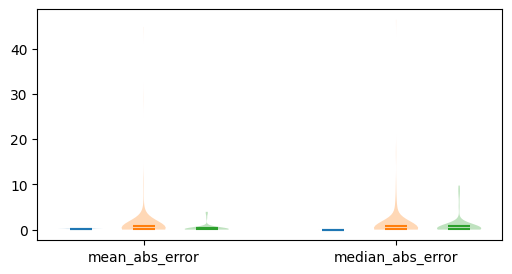

In [18]:
fig, ax = plt.subplots(figsize=(6,3))
bp1 = ax.violinplot(data1, positions=[1,5], widths=0.7, showmeans=True,
                     showextrema=False, showmedians=True, bw_method=0.5)
bp2 = ax.violinplot(data2, positions=[2,6], widths=0.7, showmeans=True,
                     showextrema=False, showmedians=True, bw_method=0.5)
bp3 = ax.violinplot(data3, positions=[3,7], widths=0.7, showmeans=True,
                     showextrema=False, showmedians=True, bw_method=0.5)

# for bp in [bp1, bp2, bp3]:
#   for median in bp['medians']:
#       median.set_color('red')
# ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], titles, loc='upper center')

plt.xticks([2, 6], ["mean_abs_error", "median_abs_error"])
plt.show()
fig.savefig("accuracy_comparison.pdf")

# Heat Map Prove Performance V.S. Historical Sequence Length and Model Types

In [1]:
# Extract perf data from the perf_log file
import os
import pandas as pd
import numpy as np

model_types = ['DLinear', 'NLinear', 'Linear']
seq_lens = [96, 192, 336, 720]
perf_metrics = ['Prove Time (S)', 'Prove CPU Usage (%)', 'Prove Max RAM (MB)']

target = '40'
pred_len = 24

df = pd.read_csv('../dataset/electricity.csv')

percent_cpu = []
prove_time = []
prove_max_ram = []
for model in model_types:
  _cpu = []
  _time = []
  _max_ram = []
  for seq_len in seq_lens:
    basepath = '../checkpoints/Electricity_{}_{}_{}_custom_ftS_tg{}_sl{}_ll48_pl{}_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0'
    basepath = basepath.format(seq_len, pred_len, model, target, seq_len, pred_len)
    perf_log = os.path.join(basepath, "perf.txt")

    with open(perf_log) as f:
      log = f.readlines()
      cpu = int(log[3].split(': ')[1].split('%')[0]) # cpu in percent
      _cpu.append(cpu)
      time = float(log[4].split(':')[-1]) # time in seconds
      _time.append(time)
      ram = round(int(log[9].split(': ')[1]) / 1024, 2) # ram in megabytes
      _max_ram.append(ram)
  percent_cpu.append(_cpu)
  prove_time.append(_time)
  prove_max_ram.append(_max_ram)

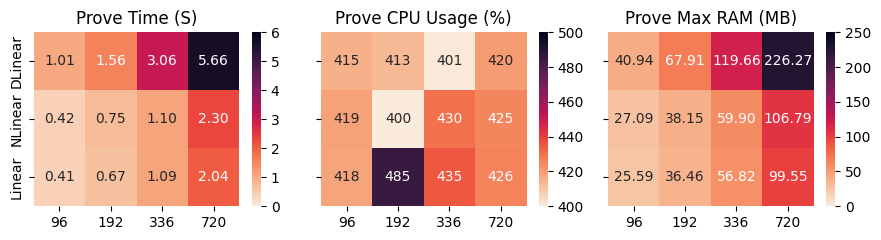

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(ncols=3, figsize=(9, 2.5), sharey=True, sharex=True)

sns.heatmap(prove_time, annot=True, fmt=".2f", cmap="rocket_r", vmin=0, vmax=6,xticklabels=seq_lens, yticklabels=model_types, ax=axes[0])
axes[0].set_title(perf_metrics[0])
sns.heatmap(percent_cpu, annot=True, fmt=".0f", cmap="rocket_r", vmin=400, vmax=500, xticklabels=seq_lens, yticklabels=model_types, ax=axes[1])
axes[1].set_title(perf_metrics[1])
sns.heatmap(prove_max_ram, annot=True, fmt=".2f", cmap="rocket_r", vmin=0, vmax=250, xticklabels=seq_lens, yticklabels=model_types, ax=axes[2])
axes[2].set_title(perf_metrics[2])

plt.tight_layout()
plt.show()
fig.savefig('zkml_perf_heatmap.pdf')